In [2]:
# Sklearn ML models
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, StratifiedKFold
from sklearn.feature_selection import SelectPercentile, chi2, SelectKBest, mutual_info_classif, RFECV
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [3]:
# Python requistes
from collections import Counter
from scipy.sparse import csr_matrix, hstack
from tqdm import tqdm

import numpy as np
import time
import pandas as pd
import os
import re

import matplotlib.pyplot as plt

In [4]:
# Graph / Visualization
from networkx.drawing.nx_agraph import graphviz_layout
import networkx as nx
import pygraphviz

In [5]:
# Tweet preprocessor
import preprocessor as p

In [175]:
# NLTK tokenization / lemmatization
import nltk

from nltk.tokenize import treebank
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer

from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.corpus.reader import WordListCorpusReader

from nltk.wsd import lesk

from nltk.stem.wordnet import WordNetLemmatizer

import nltk.sentiment

In [7]:
# Better WSD library
from pywsd.lesk import simple_lesk, original_lesk, cosine_lesk, adapted_lesk
from pywsd import disambiguate
from pywsd.similarity import max_similarity


## Tokenization / Negation / Lemmatization / Disambiguation

In [93]:
file_path = "./dataset/semEval_train_2016/semeval_train_A.txt"
file = open(file_path,"r")
labels = []
tweets = []
for line in file:
    split_string = line.split("\t")
    if len(split_string) == 2:
        tweets.append(split_string[0])
        labels.append(split_string[1])
print(len(tweets))
print(len(labels))
print(tweets[0])

11692
11692
dec 21st 2012 will be know not as the end of the world but the Baby Boom! #2012shit


In [94]:
# Negation

replace_dict = {
    "don't": "do not",
    "won't": "will not",
    "didn't": "did not",
    "doesn't": "does not",
    "can't": "can not",
    "couldn't": "could not",
    "isn't": "is not",
    "shouldn't": "should not",
    "wouldn't": "would not",
    "wasn't": "was not",
    "weren't": "were not",
    "haven't": "have not",
    "ain't": "is not",
    "aren't": "are not",
}

def replace_word(text):
    for word in replace_dict:
        if word in text:  # Small first letter
            text = text.replace(word, replace_dict[word])
        elif word[0].title() + word[1:] in text:  # Big first letter
            text = text.replace(word[0].title() + word[1:],
                                replace_dict[word][0].title() + replace_dict[word][1:])

    return text

def neg_tagging(word_list):
    string = ' '.join(word_list)
    transformed = re.sub(r'\b(?:not|never|no)\b[\w\s]+[^\w\s]', 
           lambda match: re.sub(r'(\s+)(\w+)', r'\1NEG_\2', match.group(0)), 
           string,
           flags=re.IGNORECASE)
    
    return transformed


In [95]:
def negate(word_list):
    negged_sentence = neg_tagging(word_list)
    negged_tokens = negged_sentence.split()

    tokens = []
    token_pair_list = []
    
    for word in negged_tokens:
        negation = False
        if word.startswith('NEG_'):
            negation = True
            word = word[4:]
        token_pair_list.append((word, negation))
        tokens.append(word)
    
    return tokens, token_pair_list

### To get better Word Sense Disambiguation, we're only going to pick some of these.

1.	CC	Coordinating conjunction
2.	CD	Cardinal number
3.	DT	Determiner
4.	EX	Existential there
5.	FW	Foreign word
6.	IN	Preposition or subordinating conjunction
7.	JJ	Adjective
8.	JJR	Adjective, comparative
9.	JJS	Adjective, superlative
10.	LS	List item marker
11.	MD	Modal
12.	NN	Noun, singular or mass
13.	NNS	Noun, plural
14.	NNP	Proper noun, singular
15.	NNPS	Proper noun, plural
16.	PDT	Predeterminer
17.	POS	Possessive ending
18.	PRP	Personal pronoun
19.	PRPS	Possessive pronoun
20.	RB	Adverb
21.	RBR	Adverb, comparative
22.	RBS	Adverb, superlative
23.	RP	Particle
24.	SYM	Symbol
25.	TO	to
26.	UH	Interjection
27.	VB	Verb, base form
28.	VBD	Verb, past tense
29.	VBG	Verb, gerund or present participle
30.	VBN	Verb, past participle
31.	VBP	Verb, non-3rd person singular present
32.	VBZ	Verb, 3rd person singular present
33.	WDT	Wh-determiner
34.	WP	Wh-pronoun
35.	WPS	Possessive wh-pronoun
36.	WRB	Wh-adverb


### (1) Using cosine lesk + Custom selection of POS tags. (for better results)

In [12]:
for i in range(30):
    
    cleaned_tweet = p.clean(tweets[i])
    replaced_tweet = replace_word(cleaned_tweet)
    replaced_tweet_list = replaced_tweet.split(" ")
    tokens, token_pair_list = negate(replaced_tweet_list)
    token_pos_list = nltk.pos_tag(tokens)
    
    print(tweets[i])
    print(cleaned_tweet)
    print("") 
    print(token_pos_list)
    print("") 
    
    assert(len(token_pos_list) == len(token_pair_list))
    
    score = 0
    for j in range(len(token_pair_list)):
        curr_neg = False
        if token_pair_list[j][1]:
            print("negated : " + token_pair_list[j][0])
            curr_neg = True
            
        ## BETTER SOLUTION (Can hand-engineer FURTHER)
        curr_pos = token_pos_list[j][1]
        if(curr_pos.startswith('N') or curr_pos.startswith('J') or \
           curr_pos.startswith('V')):
            
            ## simple_lesk, original_lesk, cosine_lesk, adapted_lesk --> cosine works best.
            curr_ss = cosine_lesk(cleaned_tweet, token_pair_list[j][0])
            curr_score = 0
            if curr_ss:
                
                ## NOT a good sentiment scoring function
                pos_score = swn.senti_synset(curr_ss.name()).pos_score() 
                neg_score = swn.senti_synset(curr_ss.name()).neg_score()
                curr_score += (pos_score - neg_score)
                if curr_neg:
                    curr_score *= -1
                print("   " + str(token_pair_list[j]) + " -> " + curr_ss.name() + " : " + str(curr_score))
                print("   definition : " + wn.synset(curr_ss.name()).definition())
                print("   pos score : " + str(pos_score))
                print("   neg score : " + str(neg_score))
                print("   obj score : " + str(swn.senti_synset(curr_ss.name()).obj_score()))
                print("")
            score += curr_score
        else:
            continue
    print("  TOTAL score = " + str(score) + " / " + labels[i])
    print("")

dec 21st 2012 will be know not as the end of the world but the Baby Boom! #2012shit
dec st will be know not as the end of the world but the Baby Boom!

[('dec', 'NN'), ('st', 'NN'), ('will', 'MD'), ('be', 'VB'), ('know', 'JJ'), ('not', 'RB'), ('as', 'IN'), ('the', 'DT'), ('end', 'NN'), ('of', 'IN'), ('the', 'DT'), ('world', 'NN'), ('but', 'CC'), ('the', 'DT'), ('Baby', 'NNP'), ('Boom!', 'NNP')]

   ('dec', False) -> december.n.01 : 0.0
   definition : the last (12th) month of the year
   pos score : 0.0
   neg score : 0.0
   obj score : 1.0

   ('be', False) -> beryllium.n.01 : 0.0
   definition : a light strong brittle grey toxic bivalent metallic element
   pos score : 0.0
   neg score : 0.0
   obj score : 1.0

   ('know', False) -> know.n.01 : 0.625
   definition : the fact of being aware of information that is known to few people
   pos score : 0.625
   neg score : 0.0
   obj score : 0.375

negated : as
negated : the
negated : end
   ('end', True) -> end.n.01 : -0.0
   definition :

Impulsively bought Resident Evil: Operation Raccoon City. Probably won't play it till tomorrow though. Have so much editing to do with .

[('Impulsively', 'RB'), ('bought', 'VBD'), ('Resident', 'NNP'), ('Evil:', 'NNP'), ('Operation', 'NNP'), ('Raccoon', 'NNP'), ('City.', 'NNP'), ('Probably', 'NNP'), ('will', 'MD'), ('not', 'RB'), ('play', 'VB'), ('it', 'PRP'), ('till', 'JJ'), ('tomorrow', 'NN'), ('though.', 'NNS'), ('Have', 'VBP'), ('so', 'RB'), ('much', 'JJ'), ('editing', 'NN'), ('to', 'TO'), ('do', 'VB'), ('with', 'IN'), ('.', '.')]

   ('bought', False) -> buy.v.01 : 0.0
   definition : obtain by purchase; acquire by means of a financial transaction
   pos score : 0.0
   neg score : 0.0
   obj score : 1.0

   ('Resident', False) -> resident.n.01 : 0.0
   definition : someone who lives at a particular place for a prolonged period or who was born there
   pos score : 0.0
   neg score : 0.0
   obj score : 1.0

   ('Operation', False) -> operation.n.01 : 0.0
   definition : the state of


   ('have', False) -> rich_person.n.01 : 0.0
   definition : a person who possesses great material wealth
   pos score : 0.0
   neg score : 0.0
   obj score : 1.0

   ('worked', False) -> work.v.01 : 0.0
   definition : exert oneself by doing mental or physical work for a purpose or out of necessity
   pos score : 0.0
   neg score : 0.0
   obj score : 1.0

   ('done', False) -> make.v.01 : 0.0
   definition : engage in
   pos score : 0.0
   neg score : 0.0
   obj score : 1.0

   ('workout', False) -> exercise.n.01 : 0.0
   definition : the activity of exerting your muscles in various ways to keep fit
   pos score : 0.0
   neg score : 0.0
   obj score : 1.0

   ('attended', False) -> attend.v.01 : 0.0
   definition : be present at (meetings, church services, university), etc.
   pos score : 0.0
   neg score : 0.0
   obj score : 1.0

   ('part', False) -> part.n.01 : 0.0
   definition : something determined in relation to something that includes it
   pos score : 0.0
   neg score : 0.0


   definition : hear with intention
   pos score : 0.0
   neg score : 0.0
   obj score : 1.0

   ('song', False) -> song.n.01 : 0.0
   definition : a short musical composition with words
   pos score : 0.0
   neg score : 0.0
   obj score : 1.0

   ('write', False) -> write.v.01 : 0.0
   definition : produce a literary work
   pos score : 0.0
   neg score : 0.0
   obj score : 1.0

  TOTAL score = 0.0 / positive


Jonathan Kozol is the leading author on educational advocacy and social equality. He will be on campus Wednesday,... http://t.co/nteU8d3w
Jonathan Kozol is the leading author on educational advocacy and social equality. He will be on campus Wednesday,...

[('Jonathan', 'NNP'), ('Kozol', 'NNP'), ('is', 'VBZ'), ('the', 'DT'), ('leading', 'VBG'), ('author', 'NN'), ('on', 'IN'), ('educational', 'JJ'), ('advocacy', 'NN'), ('and', 'CC'), ('social', 'JJ'), ('equality.', 'NN'), ('He', 'PRP'), ('will', 'MD'), ('be', 'VB'), ('on', 'IN'), ('campus', 'NN'), ('Wednesday,...', 'NNP')]

   ('

   neg score : 0.0
   obj score : 1.0

   ('person', False) -> person.n.01 : 0.0
   definition : a human being
   pos score : 0.0
   neg score : 0.0
   obj score : 1.0

   ('get', False) -> get.n.01 : 0.0
   definition : a return on a shot that seemed impossible to reach and would normally have resulted in a point for the opponent
   pos score : 0.0
   neg score : 0.0
   obj score : 1.0

   ('booth', False) -> booth.n.01 : 0.125
   definition : a table (in a restaurant or bar) surrounded by two high-backed benches
   pos score : 0.125
   neg score : 0.0
   obj score : 0.875

   ('say', False) -> say.n.01 : 0.125
   definition : the chance to speak
   pos score : 0.125
   neg score : 0.0
   obj score : 0.875

   ('story', False) -> narrative.n.01 : 0.0
   definition : a message that tells the particulars of an act or occurrence or course of events; presented in writing or drama or cinema or as a radio or television program
   pos score : 0.0
   neg score : 0.0
   obj score : 1.0

   ('w

   neg score : 0.0
   obj score : 1.0

   ('Demolition', False) -> destruction.n.02 : 0.0
   definition : an event (or the result of an event) that completely destroys something
   pos score : 0.0
   neg score : 0.0
   obj score : 1.0

   ('November', False) -> november.n.01 : 0.0
   definition : the month following October and preceding December
   pos score : 0.0
   neg score : 0.0
   obj score : 1.0

   ('th', False) -> thursday.n.01 : 0.0
   definition : the fifth day of the week; the fourth working day
   pos score : 0.0
   neg score : 0.0
   obj score : 1.0

   ('American', False) -> american.n.01 : 0.0
   definition : a native or inhabitant of the United States
   pos score : 0.0
   neg score : 0.0
   obj score : 1.0

   ('Legion', False) -> host.n.05 : 0.0
   definition : archaic terms for army
   pos score : 0.0
   neg score : 0.0
   obj score : 1.0

   ('Post', False) -> post.n.01 : 0.0
   definition : the position where someone (as a guard or sentry) stands or is assigned to

   pos score : 0.0
   neg score : 0.0
   obj score : 1.0

   ('nothing', False) -> nothing.n.01 : 0.0
   definition : a quantity of no importance
   pos score : 0.25
   neg score : 0.25
   obj score : 0.5

   ('drive', False) -> drive.n.01 : 0.0
   definition : the act of applying force to propel something
   pos score : 0.0
   neg score : 0.0
   obj score : 1.0

   ('nothing', False) -> nothing.n.01 : 0.0
   definition : a quantity of no importance
   pos score : 0.25
   neg score : 0.25
   obj score : 0.5

   ('way', False) -> manner.n.01 : 0.0
   definition : how something is done or how it happens
   pos score : 0.0
   neg score : 0.0
   obj score : 1.0

  TOTAL score = 0.125 / negative


Dr Joe will kick off his Australian Tour with a lecture at The Conscious Club in Sydney, Australia, Thursday, May 17!  http://t.co/uaqUTMgO
Dr Joe will kick off his Australian Tour with a lecture at The Conscious Club in Sydney, Australia, Thursday, May !

[('Dr', 'NNP'), ('Joe', 'NNP'), ('will', 

### (2) Using PYWSD's max-similarity disambiguation function

Semantic distance in WordNet: An experimental, application-oriented evaluation of five measures, Alexander Budanitsky and Graeme Hirst


[ftp://learning.cs.utoronto.ca/public_html/public_html/pub/gh/Budanitsky+Hirst-2001.pdf](ftp://learning.cs.utoronto.ca/public_html/public_html/pub/gh/Budanitsky+Hirst-2001.pdf)



In [13]:
for i in tqdm(range(20)):
    cleaned_tweet = p.clean(tweets[i])
    replaced_tweet = replace_word(cleaned_tweet)
    da_token_pair_list = disambiguate(replaced_tweet, max_similarity, similarity_option='res')
    
    da_token_list = []
    for pair in da_token_pair_list:
        da_token_list.append(pair[0])
    
    tokens, token_pair_list = negate(da_token_list)
    
    print("####### Tweet " + str(i) + " #######" )
    print("")
    print(tweets[i])
    print(" -> " + replaced_tweet)
    print("")
    print(da_token_list)
    print("") 
    print(da_token_pair_list)
    print("") 
    print(token_pair_list)
    print("") 

    
    assert(len(da_token_pair_list) == len(token_pair_list))
    
    score = 0
    for j in range(len(da_token_pair_list)):
        curr_neg = False
        if token_pair_list[j][1]:
            print("negated : " + token_pair_list[j][0])
            curr_neg = True
        
        curr_ss = da_token_pair_list[j][1]
        curr_score = 0
        if curr_ss:

            ## NOT a good sentiment scoring function
            pos_score = swn.senti_synset(curr_ss.name()).pos_score() 
            neg_score = swn.senti_synset(curr_ss.name()).neg_score()
            curr_score += (pos_score - neg_score)
            if curr_neg:
                curr_score *= -1
            print("   " + str(token_pair_list[j]) + " -> " + curr_ss.name() + " : " + str(curr_score))
            print("   definition : " + wn.synset(curr_ss.name()).definition())
            print("   pos score : " + str(pos_score))
            print("   neg score : " + str(neg_score))
            print("   obj score : " + str(swn.senti_synset(curr_ss.name()).obj_score()))
            print("")
            score += curr_score            
            
        else:
            continue
    print("  TOTAL score = " + str(score) + " / " + labels[i])
    print("")

  5%|▌         | 1/20 [00:22<07:09, 22.63s/it]

####### Tweet 0 #######

dec 21st 2012 will be know not as the end of the world but the Baby Boom! #2012shit
 -> dec st will be know not as the end of the world but the Baby Boom!

['dec', 'st', 'will', 'be', 'know', 'not', 'as', 'the', 'end', 'of', 'the', 'world', 'but', 'the', 'Baby', 'Boom', '!']

[('dec', Synset('december.n.01')), ('st', None), ('will', None), ('be', None), ('know', None), ('not', None), ('as', None), ('the', None), ('end', Synset('goal.n.01')), ('of', None), ('the', None), ('world', Synset('populace.n.01')), ('but', None), ('the', None), ('Baby', Synset('child.n.03')), ('Boom', Synset('boom.n.01')), ('!', None)]

[('dec', False), ('st', False), ('will', False), ('be', False), ('know', False), ('not', False), ('as', True), ('the', True), ('end', True), ('of', True), ('the', True), ('world', True), ('but', True), ('the', True), ('Baby', True), ('Boom', True), ('!', False)]

   ('dec', False) -> december.n.01 : 0.0
   definition : the last (12th) month of the year
  

 10%|█         | 2/20 [01:04<09:36, 32.00s/it]

####### Tweet 1 #######

@MacMiller hate my life, because i can't see you at the roskilde festival on saturday, promise me to come back again, SOON.
 -> hate my life, because i can not see you at the roskilde festival on saturday, promise me to come back again, SOON.

['hate', 'my', 'life', ',', 'because', 'i', 'can', 'not', 'see', 'you', 'at', 'the', 'roskilde', 'festival', 'on', 'saturday', ',', 'promise', 'me', 'to', 'come', 'back', 'again', ',', 'SOON', '.']

[('hate', Synset('hate.v.01')), ('my', None), ('life', Synset('life.n.07')), (',', None), ('because', None), ('i', None), ('can', None), ('not', None), ('see', Synset('see.v.05')), ('you', None), ('at', None), ('the', None), ('roskilde', None), ('festival', Synset('festival.n.02')), ('on', None), ('saturday', Synset('saturday.n.01')), (',', None), ('promise', Synset('promise.v.01')), ('me', None), ('to', None), ('come', Synset('do.v.04')), ('back', None), ('again', None), (',', None), ('SOON', None), ('.', None)]

[('hate', Fa

 15%|█▌        | 3/20 [01:41<09:35, 33.87s/it]

####### Tweet 2 #######

Checked out Our Lady Peace at Bluesfest tonight and spending the day at the beach for HOPE volleyball tomorrow. Gotta love summer weekends!
 -> Checked out Our Lady Peace at Bluesfest tonight and spending the day at the beach for HOPE volleyball tomorrow. Gotta love summer weekends!

['Checked', 'out', 'Our', 'Lady', 'Peace', 'at', 'Bluesfest', 'tonight', 'and', 'spending', 'the', 'day', 'at', 'the', 'beach', 'for', 'HOPE', 'volleyball', 'tomorrow', '.', 'Got', 'ta', 'love', 'summer', 'weekends', '!']

[('Checked', Synset('match.v.01')), ('out', None), ('Our', None), ('Lady', None), ('Peace', Synset('peace.n.01')), ('at', None), ('Bluesfest', None), ('tonight', Synset('tonight.n.01')), ('and', None), ('spending', Synset('spend.v.01')), ('the', None), ('day', Synset('day.n.04')), ('at', None), ('the', None), ('beach', Synset('beach.n.01')), ('for', None), ('HOPE', Synset('promise.n.02')), ('volleyball', Synset('volleyball.n.01')), ('tomorrow', Synset('tomorrow.n

 20%|██        | 4/20 [02:17<09:09, 34.36s/it]

####### Tweet 3 #######

Hello from the Foundation Trekkers! We're up in chilly Haltwhistle getting ready to trek Hadrian's wall tomorrow :-) http://t.co/MmRnhLAL
 -> Hello from the Foundation Trekkers! We're up in chilly Haltwhistle getting ready to trek Hadrian's wall tomorrow

['Hello', 'from', 'the', 'Foundation', 'Trekkers', '!', 'We', "'re", 'up', 'in', 'chilly', 'Haltwhistle', 'getting', 'ready', 'to', 'trek', 'Hadrian', "'s", 'wall', 'tomorrow']

[('Hello', Synset('hello.n.01')), ('from', None), ('the', None), ('Foundation', Synset('foundation.n.01')), ('Trekkers', Synset('trekker.n.01')), ('!', None), ('We', None), ("'re", None), ('up', None), ('in', None), ('chilly', None), ('Haltwhistle', None), ('getting', Synset('get.v.01')), ('ready', None), ('to', None), ('trek', Synset('trek.v.01')), ('Hadrian', Synset('hadrian.n.01')), ("'s", None), ('wall', Synset('rampart.n.01')), ('tomorrow', Synset('tomorrow.n.01'))]

[('Hello', False), ('from', False), ('the', False), ('Foundation

 25%|██▌       | 5/20 [02:56<08:48, 35.22s/it]

####### Tweet 4 #######

Tomorrow we will be proud to play at the Remembrance Service at South Hetton church
 -> Tomorrow we will be proud to play at the Remembrance Service at South Hetton church

['Tomorrow', 'we', 'will', 'be', 'proud', 'to', 'play', 'at', 'the', 'Remembrance', 'Service', 'at', 'South', 'Hetton', 'church']

[('Tomorrow', Synset('tomorrow.n.01')), ('we', None), ('will', None), ('be', None), ('proud', None), ('to', None), ('play', Synset('play.v.01')), ('at', None), ('the', None), ('Remembrance', Synset('memorial.n.01')), ('Service', Synset('serve.n.01')), ('at', None), ('South', Synset('south.n.03')), ('Hetton', None), ('church', Synset('church.n.02'))]

[('Tomorrow', False), ('we', False), ('will', False), ('be', False), ('proud', False), ('to', False), ('play', False), ('at', False), ('the', False), ('Remembrance', False), ('Service', False), ('at', False), ('South', False), ('Hetton', False), ('church', False)]

   ('proud', False) -> tomorrow.n.01 : 0.0
   defini

 30%|███       | 6/20 [03:36<08:25, 36.07s/it]

####### Tweet 5 #######

Impulsively bought Resident Evil: Operation Raccoon City. Probably won't play it till tomorrow though. Have so much editing to do with 06.
 -> Impulsively bought Resident Evil: Operation Raccoon City. Probably will not play it till tomorrow though. Have so much editing to do with .

['Impulsively', 'bought', 'Resident', 'Evil', ':', 'Operation', 'Raccoon', 'City', '.', 'Probably', 'will', 'not', 'play', 'it', 'till', 'tomorrow', 'though', '.', 'Have', 'so', 'much', 'editing', 'to', 'do', 'with', '.']

[('Impulsively', None), ('bought', Synset('buy.v.01')), ('Resident', Synset('resident.n.01')), ('Evil', Synset('evil.n.03')), (':', None), ('Operation', Synset('process.n.02')), ('Raccoon', Synset('raccoon.n.02')), ('City', Synset('city.n.01')), ('.', None), ('Probably', None), ('will', None), ('not', None), ('play', Synset('play.v.01')), ('it', None), ('till', None), ('tomorrow', Synset('tomorrow.n.01')), ('though', None), ('.', None), ('Have', None), ('so', None

 35%|███▌      | 7/20 [03:58<07:23, 34.12s/it]

####### Tweet 6 #######

Just arriving in madrid from Moscow Tomorrow going to HVar, Croatia
 -> Just arriving in madrid from Moscow Tomorrow going to HVar, Croatia

['Just', 'arriving', 'in', 'madrid', 'from', 'Moscow', 'Tomorrow', 'going', 'to', 'HVar', ',', 'Croatia']

[('Just', None), ('arriving', Synset('arrive.v.01')), ('in', None), ('madrid', Synset('madrid.n.01')), ('from', None), ('Moscow', Synset('moscow.n.01')), ('Tomorrow', Synset('tomorrow.n.01')), ('going', Synset('travel.v.01')), ('to', None), ('HVar', None), (',', None), ('Croatia', Synset('croatia.n.01'))]

[('Just', False), ('arriving', False), ('in', False), ('madrid', False), ('from', False), ('Moscow', False), ('Tomorrow', False), ('going', False), ('to', False), ('HVar', False), (',', False), ('Croatia', False)]

   ('Tomorrow', False) -> arrive.v.01 : 0.0
   definition : reach a destination; arrive by movement or progress
   pos score : 0.0
   neg score : 0.0
   obj score : 1.0

   ('Tomorrow', False) -> madrid.n

 40%|████      | 8/20 [04:22<06:34, 32.86s/it]

####### Tweet 7 #######

Just packing for a weekend in Liverpool and the small matter of a marathon on Sunday. First up though...Blackpool Illuminations!
 -> Just packing for a weekend in Liverpool and the small matter of a marathon on Sunday. First up though...Blackpool Illuminations!

['Just', 'packing', 'for', 'a', 'weekend', 'in', 'Liverpool', 'and', 'the', 'small', 'matter', 'of', 'a', 'marathon', 'on', 'Sunday', '.', 'First', 'up', 'though', '...', 'Blackpool', 'Illuminations', '!']

[('Just', None), ('packing', Synset('carry.v.02')), ('for', None), ('a', None), ('weekend', Synset('weekend.n.01')), ('in', None), ('Liverpool', Synset('liverpool.n.01')), ('and', None), ('the', None), ('small', None), ('matter', Synset('matter.n.03')), ('of', None), ('a', None), ('marathon', Synset('marathon.n.03')), ('on', None), ('Sunday', Synset('sunday.n.01')), ('.', None), ('First', Synset('first.n.01')), ('up', None), ('though', None), ('...', None), ('Blackpool', Synset('blackpool.n.01')), ('

 45%|████▌     | 9/20 [04:40<05:43, 31.21s/it]

####### Tweet 8 #######

Your plans of attending the Great Yorkshire Show may have been washed out because of the weather, so how about... http://t.co/fEsAtbk8
 -> Your plans of attending the Great Yorkshire Show may have been washed out because of the weather, so how about...

['Your', 'plans', 'of', 'attending', 'the', 'Great', 'Yorkshire', 'Show', 'may', 'have', 'been', 'washed', 'out', 'because', 'of', 'the', 'weather', ',', 'so', 'how', 'about', '...']

[('Your', None), ('plans', Synset('plan.n.01')), ('of', None), ('attending', Synset('attend.v.02')), ('the', None), ('Great', Synset('great.n.01')), ('Yorkshire', Synset('yorkshire.n.01')), ('Show', Synset('show.n.03')), ('may', Synset('whitethorn.n.01')), ('have', None), ('been', None), ('washed', Synset('wash.v.02')), ('out', None), ('because', None), ('of', None), ('the', None), ('weather', Synset('weather.n.01')), (',', None), ('so', None), ('how', None), ('about', None), ('...', None)]

[('Your', False), ('plans', False), ('of

 50%|█████     | 10/20 [06:04<06:04, 36.41s/it]

####### Tweet 9 #######

By the end of today I will have worked 14hrs, done my workout and attended part of Hot Jam. Hitting the ground running this Monday.
 -> By the end of today I will have worked hrs, done my workout and attended part of Hot Jam. Hitting the ground running this Monday.

['By', 'the', 'end', 'of', 'today', 'I', 'will', 'have', 'worked', 'hrs', ',', 'done', 'my', 'workout', 'and', 'attended', 'part', 'of', 'Hot', 'Jam', '.', 'Hitting', 'the', 'ground', 'running', 'this', 'Monday', '.']

[('By', None), ('the', None), ('end', Synset('goal.n.01')), ('of', None), ('today', Synset('today.n.01')), ('I', None), ('will', None), ('have', None), ('worked', Synset('work.v.02')), ('hrs', Synset('hour.n.01')), (',', None), ('done', None), ('my', None), ('workout', Synset('exercise.n.01')), ('and', None), ('attended', Synset('attend.v.02')), ('part', Synset('part.n.01')), ('of', None), ('Hot', None), ('Jam', Synset('crush.n.02')), ('.', None), ('Hitting', Synset('score.v.01')), ('

 55%|█████▌    | 11/20 [06:45<05:31, 36.85s/it]

####### Tweet 10 #######

Check out this weeks the @SixersBBL Scoop column looking back on Sat Nights win over the Thunder! http://t.co/lRto77al #smashemsixers #BBL02
 -> Check out this weeks the Scoop column looking back on Sat Nights win over the Thunder!

['Check', 'out', 'this', 'weeks', 'the', 'Scoop', 'column', 'looking', 'back', 'on', 'Sat', 'Nights', 'win', 'over', 'the', 'Thunder', '!']

[('Check', Synset('match.v.01')), ('out', None), ('this', None), ('weeks', Synset('week.n.01')), ('the', None), ('Scoop', Synset('exclusive.n.01')), ('column', Synset('column.n.04')), ('looking', Synset('look.v.02')), ('back', None), ('on', None), ('Sat', Synset('saturday.n.01')), ('Nights', Synset('night.n.01')), ('win', Synset('winnings.n.01')), ('over', None), ('the', None), ('Thunder', Synset('boom.n.01')), ('!', None)]

[('Check', False), ('out', False), ('this', False), ('weeks', False), ('the', False), ('Scoop', False), ('column', False), ('looking', False), ('back', False), ('on', Fals

 60%|██████    | 12/20 [07:45<05:10, 38.79s/it]

####### Tweet 11 #######

Three day weekend a head. Tonight Grand Bend forracing, Saturday Grand Bend with the inlaws more racing. Sunday first #Sting game for us.
 -> Three day weekend a head. Tonight Grand Bend forracing, Saturday Grand Bend with the inlaws more racing. Sunday first game for us.

['Three', 'day', 'weekend', 'a', 'head', '.', 'Tonight', 'Grand', 'Bend', 'forracing', ',', 'Saturday', 'Grand', 'Bend', 'with', 'the', 'inlaws', 'more', 'racing', '.', 'Sunday', 'first', 'game', 'for', 'us', '.']

[('Three', None), ('day', Synset('day.n.04')), ('weekend', Synset('weekend.n.01')), ('a', None), ('head', Synset('head.n.04')), ('.', None), ('Tonight', Synset('tonight.n.01')), ('Grand', Synset('thousand.n.01')), ('Bend', Synset('bend.n.01')), ('forracing', None), (',', None), ('Saturday', Synset('saturday.n.01')), ('Grand', Synset('thousand.n.01')), ('Bend', Synset('bend.n.01')), ('with', None), ('the', None), ('inlaws', None), ('more', None), ('racing', Synset('racing.n.01')), 

 65%|██████▌   | 13/20 [09:03<04:52, 41.81s/it]

####### Tweet 12 #######

Have you been inspired by Ironman Wales? Why not give triathlon a go by taking part in the Fishguard Go Tri on Sunday. http://t.co/lDfNW2fG
 -> Have you been inspired by Ironman Wales? Why not give triathlon a go by taking part in the Fishguard Go Tri on Sunday.

['Have', 'you', 'been', 'inspired', 'by', 'Ironman', 'Wales', '?', 'Why', 'not', 'give', 'triathlon', 'a', 'go', 'by', 'taking', 'part', 'in', 'the', 'Fishguard', 'Go', 'Tri', 'on', 'Sunday', '.']

[('Have', None), ('you', None), ('been', None), ('inspired', Synset('inspire.v.01')), ('by', None), ('Ironman', Synset('iron_man.n.01')), ('Wales', Synset('wale.n.01')), ('?', None), ('Why', None), ('not', None), ('give', Synset('impart.v.01')), ('triathlon', None), ('a', None), ('go', Synset('crack.n.09')), ('by', None), ('taking', Synset('take.v.02')), ('part', Synset('part.n.01')), ('in', None), ('the', None), ('Fishguard', None), ('Go', Synset('crack.n.09')), ('Tri', None), ('on', None), ('Sunday', Syns

 70%|███████   | 14/20 [09:33<04:05, 40.94s/it]

####### Tweet 13 #######

I've found lyrics of Kiryu - Kaika!!! YES!!! but I've sat down to listen a song and write it already...))
 -> I've found lyrics of Kiryu - Kaika!!! YES!!! but I've sat down to listen a song and write it already...))

['I', "'ve", 'found', 'lyrics', 'of', 'Kiryu', '-', 'Kaika', '!', '!', '!', 'YES', '!', '!', '!', 'but', 'I', "'ve", 'sat', 'down', 'to', 'listen', 'a', 'song', 'and', 'write', 'it', 'already', '...', ')', ')']

[('I', None), ("'ve", None), ('found', Synset('determine.v.01')), ('lyrics', Synset('lyric.n.01')), ('of', None), ('Kiryu', None), ('-', None), ('Kaika', None), ('!', None), ('!', None), ('!', None), ('YES', Synset('yes.n.01')), ('!', None), ('!', None), ('!', None), ('but', None), ('I', None), ("'ve", None), ('sat', Synset('sit.v.01')), ('down', None), ('to', None), ('listen', Synset('listen.v.02')), ('a', None), ('song', Synset('song.n.01')), ('and', None), ('write', Synset('write.v.02')), ('it', None), ('already', None), ('...', None), 

 75%|███████▌  | 15/20 [09:47<03:15, 39.18s/it]

####### Tweet 14 #######

Jonathan Kozol is the leading author on educational advocacy and social equality. He will be on campus Wednesday,... http://t.co/nteU8d3w
 -> Jonathan Kozol is the leading author on educational advocacy and social equality. He will be on campus Wednesday,...

['Jonathan', 'Kozol', 'is', 'the', 'leading', 'author', 'on', 'educational', 'advocacy', 'and', 'social', 'equality', '.', 'He', 'will', 'be', 'on', 'campus', 'Wednesday', ',', '...']

[('Jonathan', Synset('jonathan.n.01')), ('Kozol', None), ('is', None), ('the', None), ('leading', Synset('leave.v.07')), ('author', Synset('writer.n.01')), ('on', None), ('educational', None), ('advocacy', Synset('advocacy.n.01')), ('and', None), ('social', None), ('equality', Synset('equality.n.02')), ('.', None), ('He', None), ('will', None), ('be', None), ('on', None), ('campus', Synset('campus.n.01')), ('Wednesday', Synset('wednesday.n.01')), (',', None), ('...', None)]

[('Jonathan', False), ('Kozol', False), ('is', Fa

 80%|████████  | 16/20 [10:01<02:30, 37.56s/it]

####### Tweet 15 #######

@nurinqistinaa @hannahban4na That's the 1st.2nd: Nadia &amp; Mysa about Mysa break dgn Adam. 3rd: this bullshit thingy -.-
 -> That's the st.2nd: Nadia &amp; Mysa about Mysa break dgn Adam. rd: this bullshit thingy -.-

['That', "'s", 'the', 'st.2nd', ':', 'Nadia', '&', 'amp', ';', 'Mysa', 'about', 'Mysa', 'break', 'dgn', 'Adam', '.', 'rd', ':', 'this', 'bullshit', 'thingy', '-.-']

[('That', None), ("'s", None), ('the', None), ('st.2nd', None), (':', None), ('Nadia', None), ('&', None), ('amp', Synset('adenosine_monophosphate.n.01')), (';', None), ('Mysa', None), ('about', None), ('Mysa', None), ('break', Synset('pause.n.01')), ('dgn', None), ('Adam', Synset('adam.n.03')), ('.', None), ('rd', None), (':', None), ('this', None), ('bullshit', Synset('bullshit.n.01')), ('thingy', None), ('-.-', None)]

[('That', False), ("'s", False), ('the', False), ('st.2nd', False), (':', False), ('Nadia', False), ('&', False), ('amp', False), (';', False), ('Mysa', False), (

 85%|████████▌ | 17/20 [10:16<01:48, 36.24s/it]

####### Tweet 16 #######

Thanks to all those who joined UYSA and the University of Utah in celebrating Youth Soccer Month last Saturday,... http://t.co/39jQBGV8
 -> Thanks to all those who joined UYSA and the University of Utah in celebrating Youth Soccer Month last Saturday,...

['Thanks', 'to', 'all', 'those', 'who', 'joined', 'UYSA', 'and', 'the', 'University', 'of', 'Utah', 'in', 'celebrating', 'Youth', 'Soccer', 'Month', 'last', 'Saturday', ',', '...']

[('Thanks', Synset('thanks.n.01')), ('to', None), ('all', None), ('those', None), ('who', None), ('joined', Synset('join.v.04')), ('UYSA', None), ('and', None), ('the', None), ('University', Synset('university.n.02')), ('of', None), ('Utah', Synset('utah.n.01')), ('in', None), ('celebrating', Synset('celebrate.v.02')), ('Youth', Synset('young_person.n.01')), ('Soccer', Synset('soccer.n.01')), ('Month', Synset('calendar_month.n.01')), ('last', None), ('Saturday', Synset('saturday.n.01')), (',', None), ('...', None)]

[('Thanks', Fa

 90%|█████████ | 18/20 [11:00<01:13, 36.70s/it]

####### Tweet 17 #######

@pkollar Well it was either that or watch you play Raccoon City, so.. I think I may have won?
 -> Well it was either that or watch you play Raccoon City, so.. I think I may have won?

['Well', 'it', 'was', 'either', 'that', 'or', 'watch', 'you', 'play', 'Raccoon', 'City', ',', 'so..', 'I', 'think', 'I', 'may', 'have', 'won', '?']

[('Well', None), ('it', None), ('was', None), ('either', None), ('that', None), ('or', None), ('watch', Synset('watch.v.01')), ('you', None), ('play', Synset('play.v.01')), ('Raccoon', Synset('raccoon.n.02')), ('City', Synset('city.n.01')), (',', None), ('so..', None), ('I', None), ('think', Synset('think.v.03')), ('I', None), ('may', Synset('whitethorn.n.01')), ('have', None), ('won', Synset('gain.v.05')), ('?', None)]

[('Well', False), ('it', False), ('was', False), ('either', False), ('that', False), ('or', False), ('watch', False), ('you', False), ('play', False), ('Raccoon', False), ('City', False), (',', False), ('so..', False

 95%|█████████▌| 19/20 [11:53<00:37, 37.57s/it]

####### Tweet 18 #######

Day 1 at the SoCal College Fair @ Pomona Fairplex--1st person to get to our booth &amp; say "your story matters" wins something special! #doit
 -> Day at the SoCal College Fair Pomona Fairplex--1st person to get to our booth &amp; say "your story matters" wins something special!

['Day', 'at', 'the', 'SoCal', 'College', 'Fair', 'Pomona', 'Fairplex', '--', '1st', 'person', 'to', 'get', 'to', 'our', 'booth', '&', 'amp', ';', 'say', '``', 'your', 'story', 'matters', "''", 'wins', 'something', 'special', '!']

[('Day', Synset('day.n.04')), ('at', None), ('the', None), ('SoCal', None), ('College', Synset('college.n.02')), ('Fair', Synset('carnival.n.03')), ('Pomona', None), ('Fairplex', None), ('--', None), ('1st', None), ('person', Synset('person.n.01')), ('to', None), ('get', Synset('get.v.01')), ('to', None), ('our', None), ('booth', Synset('booth.n.04')), ('&', None), ('amp', Synset('adenosine_monophosphate.n.01')), (';', None), ('say', Synset('state.v.01')), (

100%|██████████| 20/20 [12:37<00:00, 37.89s/it]

####### Tweet 19 #######

De La Soul's First Serve project with Live Band debuts this Thu 18th in Meeting House Square, ONRA supports on MPC  http://t.co/DN2SfycQ!!!
 -> De La Soul's First Serve project with Live Band debuts this Thu th in Meeting House Square, ONRA supports on MPC !!!

['De', 'La', 'Soul', "'s", 'First', 'Serve', 'project', 'with', 'Live', 'Band', 'debuts', 'this', 'Thu', 'th', 'in', 'Meeting', 'House', 'Square', ',', 'ONRA', 'supports', 'on', 'MPC', '!', '!', '!']

[('De', Synset('delaware.n.04')), ('La', Synset('louisiana.n.01')), ('Soul', Synset('person.n.01')), ("'s", None), ('First', Synset('first.n.01')), ('Serve', Synset('serve.n.01')), ('project', Synset('undertaking.n.01')), ('with', None), ('Live', None), ('Band', Synset('set.n.05')), ('debuts', Synset('debut.v.01')), ('this', None), ('Thu', None), ('th', Synset('thursday.n.01')), ('in', None), ('Meeting', Synset('meeting.n.01')), ('House', Synset('firm.n.01')), ('Square', Synset('public_square.n.01')), (','

### ** Comparing different WSD methods

In [ ]:
list = disambiguate('I went to the bank to deposit my money')
for item in list:
    print(item)
    if item[1]:
        print("    : " + item[1].definition())
    print("")

### Among similarity options, 'res' seems to do the best.

In [111]:
for so in ['lch', 'res', 'jcn', 'lin', 'path', 'wup']:
    print("-- " + so + " --")
    list = disambiguate('I went to the bank to deposit my money', max_similarity, similarity_option=so)
    for item in list:
        print(item)
        if item[1]:
            print("    : " + item[1].definition())
    print("")

-- lch --
('I', None)
('went', Synset('travel.v.01'))
    : change location; move, travel, or proceed, also metaphorically
('to', None)
('the', None)
('bank', Synset('savings_bank.n.02'))
    : a container (usually with a slot in the top) for keeping money at home
('to', None)
('deposit', Synset('deposit.v.02'))
    : put into a bank account
('my', None)
('money', Synset('money.n.03'))
    : the official currency issued by a government or national bank

-- res --
('I', None)
('went', Synset('travel.v.01'))
    : change location; move, travel, or proceed, also metaphorically
('to', None)
('the', None)
('bank', Synset('depository_financial_institution.n.01'))
    : a financial institution that accepts deposits and channels the money into lending activities
('to', None)
('deposit', Synset('situate.v.02'))
    : put (something somewhere) firmly
('my', None)
('money', Synset('money.n.01'))
    : the most common medium of exchange; functions as legal tender

-- jcn --
('I', None)
('went', Sy

### Among 'lesk', 'cosine' lesk does the best.

In [112]:
i=0
for method in [simple_lesk, original_lesk, adapted_lesk, cosine_lesk]:
    i += 1
    print("--" + str(i))
    list = disambiguate('I went to the bank to deposit my money', method)
    for item in list:
        print(item)
        if item[1]:
            print("    : " + item[1].definition())
    print("")

--1
('I', None)
('went', Synset('run_low.v.01'))
    : to be spent or finished
('to', None)
('the', None)
('bank', Synset('bank.n.09'))
    : a building in which the business of banking transacted
('to', None)
('deposit', Synset('deposit.v.02'))
    : put into a bank account
('my', None)
('money', Synset('money.n.03'))
    : the official currency issued by a government or national bank

--2
('I', None)
('went', Synset('go.n.01'))
    : a time for working (after which you will be relieved by someone else)
('to', None)
('the', None)
('bank', Synset('bank.n.01'))
    : sloping land (especially the slope beside a body of water)
('to', None)
('deposit', Synset('deposit.n.01'))
    : the phenomenon of sediment or gravel accumulating
('my', None)
('money', Synset('money.n.01'))
    : the most common medium of exchange; functions as legal tender

--3
('I', None)
('went', Synset('run_low.v.01'))
    : to be spent or finished
('to', None)
('the', None)
('bank', Synset('bank.n.09'))
    : a build

### Too many bad examples of sentiment scoring using Built-in SentiWordNet

e.g.

great.n.01 : 0.0

party.n.01 : 0.0

excite.v.01 : -0.125

In [40]:
swn.senti_synset(wn.synset('good.a.01').name()).neg_score()

0.0

In [38]:
wn.synset('good.a.01').definition()

'having desirable or positive qualities especially those suitable for a thing specified'

### REF: Simply using a Built-in Sentiment Classifier

nltk.sentiment.util.demo_liu_hu_lexicon(sentence, plot=False)[source]
nltk.sentiment.vader.SentimentIntensityAnalyzer(lexicon_file='sentiment/vader_lexicon.zip/vader_lexicon/vader_lexicon.txt')[source]

### REF: WordNet corpus provides the distance value inbetween synsets, but it's based on hypernym relationship.

synset1.path_similarity(synset2): Return a score denoting how similar two word senses are, based on the shortest path that connects the senses in the is-a (hypernym/hypnoym) taxonomy.

synset1.res_similarity(synset2, ic): Resnik Similarity: Return a score denoting how similar two word senses are, based on the Information Content (IC) of the Least Common Subsumer (most specific ancestor node). 

synset1.wup_similarity(synset2): Wu-Palmer Similarity: Return a score denoting how similar two word senses are, based on the depth of the two senses in the taxonomy and that of their Least Common Subsumer (most specific ancestor node).

synset1.res_similarity(synset2, ic): Resnik Similarity: Return a score denoting how similar two word senses are, based on the Information Content (IC) of the Least Common Subsumer (most specific ancestor node). 

synset1.jcn_similarity(synset2, ic): Jiang-Conrath Similarity Return a score denoting how similar two word senses are, based on the Information Content (IC) of the Least Common Subsumer (most specific ancestor node) and that of the two input Synsets.

synset1.lin_similarity(synset2, ic): Lin Similarity: Return a score denoting how similar two word senses are, based on the Information Content (IC) of the Least Common Subsumer (most specific ancestor node) and that of the two input Synsets.


### Also, we could use built-in Bing Liu lexicon based sentiment analysis

Positive


/Users/kaka/tm3-env/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


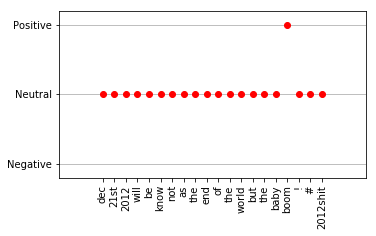

In [135]:
nltk.sentiment.util.demo_liu_hu_lexicon(tweets[0], plot=True)

### Or, built-in Vader classifier

In [162]:
vader_analyzer = nltk.sentiment.vader.SentimentIntensityAnalyzer(lexicon_file='sentiment/vader_lexicon.zip/vader_lexicon/vader_lexicon.txt')

In [163]:
vader_analyzer.polarity_scores(tweets[0])

{'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0}

In [141]:
nltk.sentiment.util.demo_vader_instance(tweets[0])

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


In [172]:
nltk.sentiment.vader.allcap_differential("this song is really AWESOME!!!")

True

In [173]:
nltk.sentiment.vader.allcap_differential("AWESOME")

False

In [139]:
nltk.sentiment.util.demo_vader_tweets()

Loaded 5000 tweets


Loaded 5000 tweets
Accuracy: 0.86
F-measure [neg]: 0.851063829787234
F-measure [pos]: 0.8679245283018868
Precision [neg]: 0.9090909090909091
Precision [pos]: 0.8214285714285714
Recall [neg]: 0.8
Recall [pos]: 0.92


### Built-in negation util is not very good, so we'll implement one.

In [142]:
nltk.sentiment.util.mark_negation(tweets[0], double_neg_flip=False, shallow=False)

'dec 21st 2012 will be know not as the end of the world but the Baby Boom! #2012shit'

In [164]:
pairs = nltk.sentiment.util.pairwise(tweets[0].split(' '))

In [165]:
for t in pairs:
    print(t)

('dec', '21st')
('21st', '2012')
('2012', 'will')
('will', 'be')
('be', 'know')
('know', 'not')
('not', 'as')
('as', 'the')
('the', 'end')
('end', 'of')
('of', 'the')
('the', 'world')
('world', 'but')
('but', 'the')
('the', 'Baby')
('Baby', 'Boom!')
('Boom!', '#2012shit')


## WordNet graphical model used for word sense disambiguation

In [59]:
lemmas_in_words  = set(i for i in wn.words())

### Basic WordNet Graph

In [60]:
seen = set()
wordnet_graph = nx.Graph(engine='sfdp', pack=True)
for word in tqdm(lemmas_in_words):
    wordnet_graph.add_node(word)
    for dw in wn.synsets(word):
        if not dw in seen:
            seen.add(dw)
            wordnet_graph.add_node(dw.name())
        wordnet_graph.add_edge(dw.name(), word)

100%|██████████| 147306/147306 [00:05<00:00, 27375.63it/s]


In [61]:
path = './wordnet_graph.p'
nx.write_gpickle(wordnet_graph, path)

### Cleanedup version

In [62]:
# new cleaned wordnet graph

wordnet_graph_cleaned = nx.Graph(engine='sfdp', pack=True)

for word in tqdm(lemmas_in_words):
    wordnet_graph_cleaned.add_node(word)

for word in tqdm(lemmas_in_words):
    nb_list = [k for m in [n for n in wordnet_graph.neighbors(word)] for k in wordnet_graph.neighbors(m)]    
    for nb in nb_list:
        if wordnet_graph_cleaned.has_edge(word, nb) == False:
            wordnet_graph_cleaned.add_edge(word, nb)


100%|██████████| 147306/147306 [00:02<00:00, 70071.57it/s]


In [18]:
ps = [p for p in nx.all_shortest_paths(wordnet_graph_cleaned, 'good', 'bad')]

In [19]:
for p in ps:
    print(p)

['good', 'well', 'swelled', 'bigger', 'bad']
['good', 'sound', 'heavy', 'bigger', 'bad']
['good', 'sounder', 'heavy', 'bigger', 'bad']
['good', 'well', 'swelled', 'big', 'bad']
['good', 'sound', 'heavy', 'big', 'bad']
['good', 'sounder', 'heavy', 'big', 'bad']


### Chekcing words near 'good'

In [20]:
ncc_good = nx.node_connected_component(wordnet_graph_cleaned, 'good')

In [21]:
# check words near 'good'
distance = 2
good_words = []
for word in tqdm(ncc_good):
    if nx.shortest_path_length(wordnet_graph_cleaned, 'good', word) <= distance:
        good_words.append(word)


100%|██████████| 32011/32011 [00:11<00:00, 2700.60it/s]


In [22]:
len(good_words)

311

In [23]:
subg_good = nx.Graph(wordnet_graph_cleaned.subgraph(good_words), engine = 'sfdp')

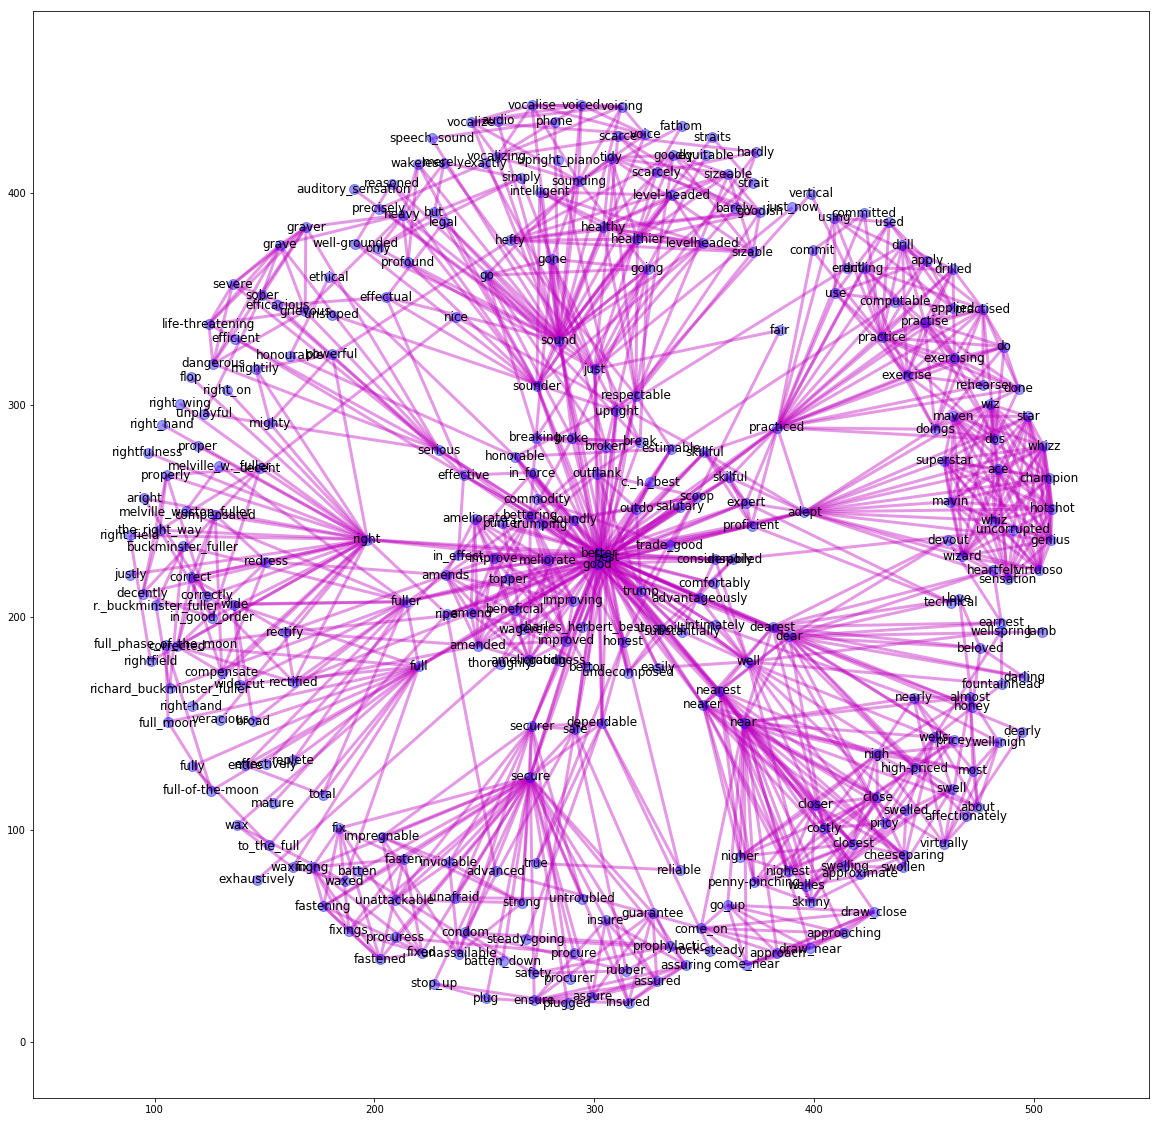

In [24]:
pos = graphviz_layout(subg_good)

plt.figure(figsize=(20, 20)) 

nx.draw_networkx_nodes(subg_good,pos,node_size=100,node_color='b',alpha=0.4)
nx.draw_networkx_edges(subg_good,pos,alpha=0.4,node_size=0,width=3,edge_color='m')
nx.draw_networkx_labels(subg_good,pos,fontsize=6)
plt.show()

## Instead, we decided to build a graph using synsets.

#### In the paper, they created a graph based on paths between actual lemmas. 
#### However, we're going to try a graphical model using only synset because they provide more accurate(diambiguated) sense for any sentence.

In [31]:
len(list(wn.all_synsets()))

117659

In [21]:
wn.synset('dog.n.02').lemmas()

[Lemma('frump.n.01.frump'), Lemma('frump.n.01.dog')]

In [33]:
wordnet_graph_synset = nx.Graph(engine='sfdp', pack=True)

seen = set()
for ss in tqdm(synset_list):
    wordnet_graph_synset.add_node(ss.name())
    for lm in ss.lemmas():
        _lm = lm.name()
        if not _lm in seen:
            seen.add(_lm)
            wordnet_graph_synset.add_node(_lm)
        wordnet_graph_synset.add_edge(_lm, ss.name())


100%|██████████| 117659/117659 [00:01<00:00, 81846.14it/s]


In [34]:
wordnet_graph_synset.size()

206978

In [35]:
# new cleaned wordnet SYNSET graph
wordnet_graph_synset_cleaned = nx.Graph(engine='sfdp', pack=True)

for ss in tqdm(synset_list):
    wordnet_graph_synset_cleaned.add_node(ss.name())

for ss in tqdm(synset_list):
    nb_list = [k for m in [n for n in wordnet_graph_synset.neighbors(ss.name())] for k in wordnet_graph_synset.neighbors(m)]    
    for nb in nb_list:
        if wordnet_graph_synset_cleaned.has_edge(ss.name(), nb) == False:
            wordnet_graph_synset_cleaned.add_edge(ss.name(), nb)


100%|██████████| 117659/117659 [00:02<00:00, 56896.86it/s]


### Chekcing synsets near 'good.a.01'

In [36]:
ncc_good_a_01 = nx.node_connected_component(wordnet_graph_synset_cleaned, 'good.a.01')
distance = 2
good_synsets = []
for ss in tqdm(ncc_good_a_01):
    if nx.shortest_path_length(wordnet_graph_synset_cleaned, 'good.a.01', ss) <= distance:
        good_synsets.append(ss)

100%|██████████| 32133/32133 [00:23<00:00, 1356.39it/s]


In [37]:
good_synsets

['right.r.07',
 'dangerous.s.02',
 'equitable.a.01',
 'dearly.r.03',
 'sound.a.01',
 'advanced.s.06',
 'guarantee.v.02',
 'right.a.07',
 'right.n.04',
 'well.n.02',
 'secure.a.01',
 'near.a.01',
 'just.a.01',
 'wax.v.03',
 'sound.v.03',
 'right.n.01',
 'impregnable.s.01',
 'well.r.07',
 'sound.n.01',
 'costly.s.02',
 'sound.v.02',
 'good.s.12',
 'honest.s.02',
 'dear.s.02',
 'dependable.s.03',
 'full_moon.n.01',
 'effective.s.04',
 'well.r.09',
 'technical.a.01',
 'lamb.n.04',
 'correct.v.01',
 'right.n.07',
 'sound.v.06',
 'good.s.21',
 'wide.s.06',
 'uncorrupted.s.02',
 'expert.n.01',
 'safe.n.01',
 'sound.n.04',
 'safe.s.02',
 'reasoned.s.01',
 'right.v.03',
 'precisely.r.01',
 'well.r.01',
 'right.v.02',
 'well.v.01',
 'well.r.10',
 'right.n.05',
 'audio.n.01',
 'approximate.s.02',
 'cheeseparing.s.01',
 'good.s.20',
 'well.r.13',
 'just.r.06',
 'goodly.s.01',
 'sound.n.02',
 'ace.n.03',
 'upright.s.01',
 'sound.s.09',
 'safe.a.03',
 'honorable.a.02',
 'good.a.03',
 'right_field.n.

In [39]:
subg_good = nx.Graph(wordnet_graph_synset_cleaned.subgraph(good_synsets), engine = 'sfdp')

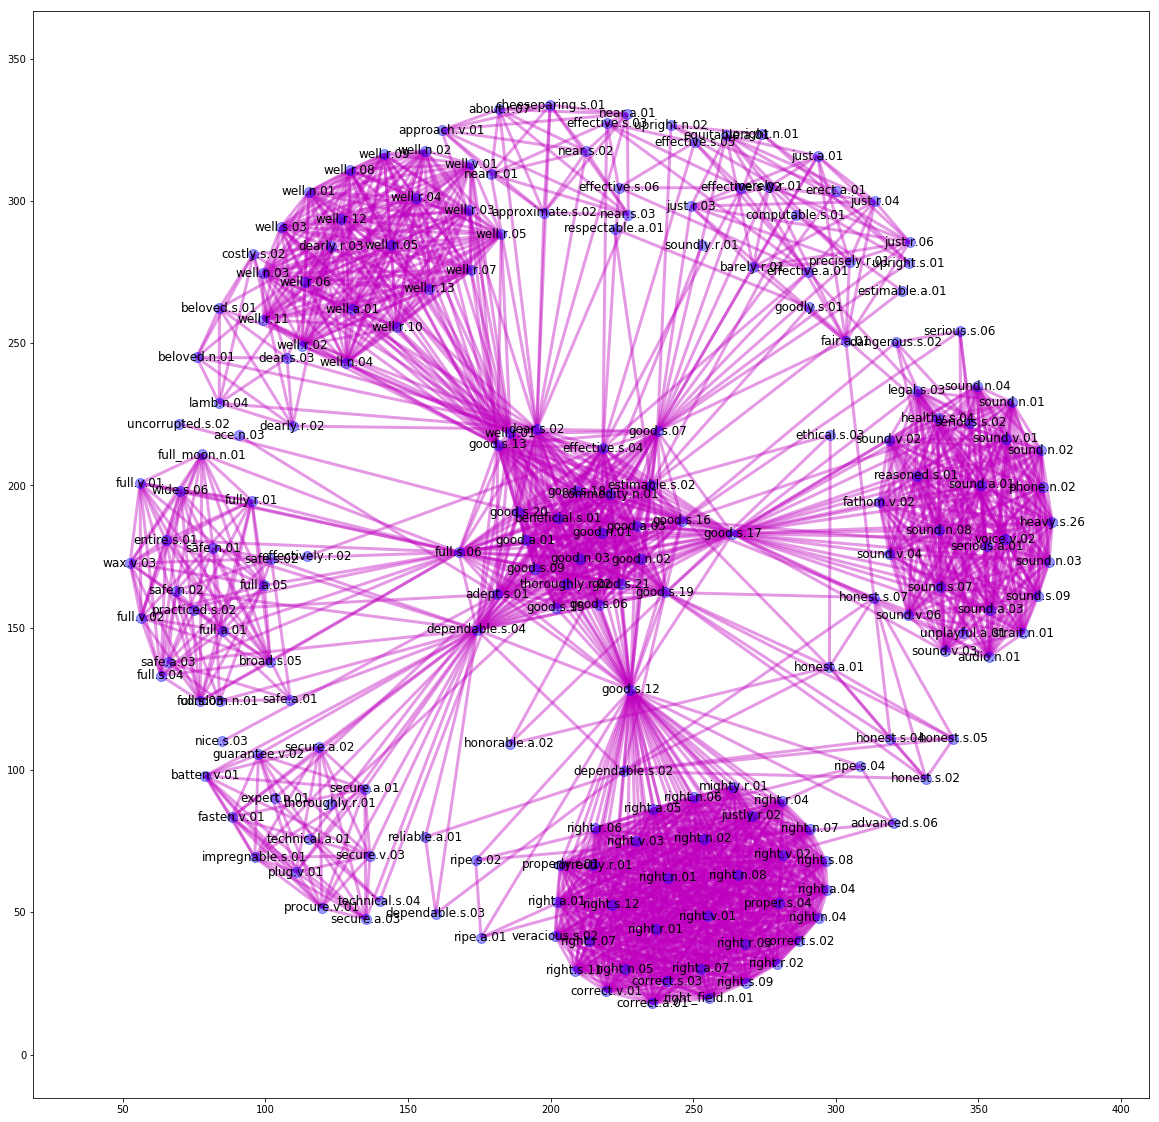

In [40]:
pos = graphviz_layout(subg_good)

plt.figure(figsize=(20, 20)) 

nx.draw_networkx_nodes(subg_good,pos,node_size=100,node_color='b',alpha=0.4)
nx.draw_networkx_edges(subg_good,pos,alpha=0.4,node_size=0,width=3,edge_color='m')
nx.draw_networkx_labels(subg_good,pos,fontsize=6)
plt.show()


### Distance estimated from positive/negative words

In [63]:
def DIST_word(word, graph, p_word='good', n_word='bad'):
    if graph.has_node(word) and graph.has_node(p_word) and graph.has_node(n_word):

        if nx.has_path(graph, p_word, n_word):
            p_n = nx.shortest_path_length(graph, p_word, n_word)
        else:
            print('No path between '+ n_word + ' and ' + p_word)
            return 0
        
        if nx.has_path(graph, word, n_word):
            n_w = nx.shortest_path_length(graph, n_word, word)
        else:
            return 0
        
        if nx.has_path(graph, word, p_word):
            p_w = nx.shortest_path_length(graph, p_word, word)
        else:
            return 0

        print('distance to '+ n_word + ' : ' + str(n_w))
        print('distance to '+ p_word + ' : ' + str(p_w))
        print('distance between '+ n_word + ' and ' + p_word + ' : ' + str(p_n))
        return (n_w - p_w) / p_n
    else :
        print(word + ' is not in the graph.')
        return 0

In [64]:
DIST_word('happy', wordnet_graph_cleaned)

distance to bad : 7
distance to good : 6
distance between bad and good : 4


0.25

In [65]:
DIST_word('sad', wordnet_graph_cleaned)

distance to bad : 2
distance to good : 5
distance between bad and good : 4


-0.75

In [66]:
DIST_word('fuck', wordnet_graph_cleaned)

distance to bad : 5
distance to good : 3
distance between bad and good : 4


0.5

In [67]:
DIST_word('awkward', wordnet_graph_cleaned)

distance to bad : 4
distance to good : 5
distance between bad and good : 4


-0.25

### Distance estimated from positive/negative SYNSETS

In [41]:
wn.synset('good.a.01').definition()

'having desirable or positive qualities especially those suitable for a thing specified'

In [42]:
wn.synset('bad.a.01').definition()

'having undesirable or negative qualities'

In [216]:
def DIST_synset(ss, graph, p_ss='good.a.01', n_ss='bad.a.01'):
    _ss = ss
#     print(wn.synset(ss).definition())
    if graph.has_node(_ss) and graph.has_node(p_ss) and graph.has_node(n_ss):

        if nx.has_path(graph, p_ss, n_ss):
            p_n = nx.shortest_path_length(graph, p_ss, n_ss)
        else:
#             print('No path between '+ p_ss + ' and ' + n_ss)
            return 0
        
        if nx.has_path(graph, _ss, n_ss):
            n_w = nx.shortest_path_length(graph, n_ss, _ss)
        else:
            return 0
        
        if nx.has_path(graph, _ss, p_ss):
            p_w = nx.shortest_path_length(graph, p_ss, _ss)
        else:
            return 0

#         print('distance to '+ n_ss + ' : ' + str(n_w))
#         print('distance to '+ p_ss + ' : ' + str(p_w))
#         print('distance between '+ n_ss + ' and ' + p_ss + ' : ' + str(p_n))
        return (n_w - p_w) / p_n
    else :
        print(_ss + ' is not in the graph.')
        return 0

In [205]:
DIST_synset('happy.a.01', wordnet_graph_synset_cleaned)

enjoying or showing or marked by joy or pleasure
distance to bad.a.01 : 10
distance to good.a.01 : 9
distance between bad.a.01 and good.a.01 : 5


0.2

In [54]:
DIST_synset('sad.a.01', wordnet_graph_synset_cleaned)

experiencing or showing sorrow or unhappiness
distance to bad.a.01 : 3
distance to good.a.01 : 6
distance between bad.a.01 and good.a.01 : 5


-0.6

In [89]:
wn.synsets('awkward')

[Synset('awkward.s.01'),
 Synset('awkward.a.02'),
 Synset('awkward.s.03'),
 Synset('awkward.s.04'),
 Synset('awkward.s.05'),
 Synset('awkward.s.06')]

In [90]:
DIST_synset('awkward.a.02', wordnet_graph_synset)

lacking grace or skill in manner or movement or performance
distance to bad.a.01 : 14
distance to good.a.01 : 16
distance between bad.a.01 and good.a.01 : 10


-0.2

In [87]:
wn.synsets('fucking')

[Synset('fuck.n.01'),
 Synset('sleep_together.v.01'),
 Synset('bally.s.01'),
 Synset('fucking.r.01')]

In [88]:
DIST_synset('fucking.r.01', wordnet_graph_synset)

intensifier, very colloquial
distance to bad.a.01 : 12
distance to good.a.01 : 10
distance between bad.a.01 and good.a.01 : 10


0.2

In [179]:
DIST_synset('fucking.r.01', wordnet_graph_synset_cleaned)

intensifier, very colloquial
distance to bad.a.01 : 6
distance to good.a.01 : 5
distance between bad.a.01 and good.a.01 : 5


0.2

## (3) Using graphical model for disambiguation

In [124]:
wn.synsets('better-known')

[Synset('better-known.s.01')]

In [108]:
wn.synset('positive.a.01').definition()

'characterized by or displaying affirmation or acceptance or certainty etc.'

In [123]:
wn.synset('good.a.01').lemmas()[0].antonyms()[0]

Lemma('bad.a.01.bad')

In [118]:
wn.synset('positive.a.01').definition()

'positive.a.01'

### Using opinion_lexicon (Bing Liu sentiment lexicons)

#### A list of positive and negative opinion words or sentiment words for English.

 from nltk.corpus import opinion_lexicon

 opinion_lexicon.words()[:4]


['2-faced', '2-faces', 'abnormal', 'abolish']


#### The OpinionLexiconCorpusReader also provides shortcuts to retrieve positive/negative words:

 opinion_lexicon.negative()[:4]


['2-faced', '2-faces', 'abnormal', 'abolish']


#### Note that words from words() method in opinion_lexicon are sorted by file id, not alphabetically:

 opinion_lexicon.words()[0:10]


['2-faced', '2-faces', 'abnormal', 'abolish', 'abominable', 'abominably',
'abominate', 'abomination', 'abort', 'aborted']


sorted(opinion_lexicon.words())[0:10]


['2-faced', '2-faces', 'a+', 'abnormal', 'abolish', 'abominable', 'abominably',
'abominate', 'abomination', 'abort']

In [176]:
from nltk.corpus import opinion_lexicon

In [177]:
len(opinion_lexicon.positive())

2006

In [178]:
len(opinion_lexicon.negative())

4783

In [ ]:
len(opinion_lexicon.positive())

In [207]:
## Prepare all antonyms for every word in opinion lexicon

bingliu_pos_synset_pair_list = []
for word in opinion_lexicon.positive():
    for i in wn.synsets(word):
        # if i.pos() in ['a', 's', 'r', 'v']: # no nouns
        for j in i.lemmas(): 
            if j.antonyms(): 
                bingliu_pos_synset_pair_list.append((j.synset().name(), j.antonyms()[0].synset().name()))

bingliu_neg_synset_pair_list = []
for word in opinion_lexicon.negative():
    for i in wn.synsets(word):
        # if i.pos() in ['a', 's', 'r', 'v']: # no nouns
        for j in i.lemmas(): 
            if j.antonyms(): 
                ## NOTE that we put antonyms first
                bingliu_neg_synset_pair_list.append((j.antonyms()[0].synset().name(), j.synset().name()))

In [208]:
len(bingliu_pos_synset_pair_list)

1284

In [209]:
len(bingliu_neg_synset_pair_list)

1868

In [ ]:
[('good.a.01', 'bad.a.01')]

In [220]:
def GetSentenceSentiScore(tweet_sentence, label, graph, cmp_ss_pair_lists):
    cleaned_tweet = p.clean(tweet_sentence)
    replaced_tweet = replace_word(cleaned_tweet)
    
    ## (1) Can replace this by using other WSD options (different Lesk algorithms / similarity options)
    da_token_pair_list = disambiguate(replaced_tweet, max_similarity, similarity_option='res')
    
    da_token_list = []
    for pair in da_token_pair_list:
        da_token_list.append(pair[0])
    
    tokens, token_pair_list = negate(da_token_list)
    
#     print("####### Tweet #######" )
#     print("")
#     print(tweet_sentence)
#     print(" -> " + replaced_tweet)
#     print("")
#     print(da_token_list)
#     print("") 
#     print(da_token_pair_list)
#     print("") 
#     print(token_pair_list)
#     print("")     
    
    assert(len(da_token_pair_list) == len(token_pair_list))
    
    score = 0
    for j in range(len(da_token_pair_list)):
        curr_neg = False
        if token_pair_list[j][1]:
#             print("negated : " + token_pair_list[j][0])
            curr_neg = True
        
        curr_ss = da_token_pair_list[j][1]
        curr_score = 0
        if curr_ss:
            for cmp_ss_pair_list in cmp_ss_pair_lists:
                for cmp_ss_pair in cmp_ss_pair_list:
                    curr_score += DIST_synset(curr_ss.name(), graph, cmp_ss_pair[0], cmp_ss_pair[1])
                curr_score /= len(cmp_ss_pair_list)
            
            if curr_neg:
                curr_score *= -1
                
#             print("   " + str(token_pair_list[j]) + " -> " + curr_ss.name() + " : " + str(curr_score))
#             print("   definition : " + wn.synset(curr_ss.name()).definition())
#             print("   score from graph : " + str(curr_score))
#             print("")
            score += curr_score            
            
        else:
            continue
    print("Tweet " + str(i) + " : TOTAL score = " + str(score) + " / " + label)
#     print("")
    
    return score

In [222]:
import time

In [224]:
## testing a few tweets
for i in range(1):
    start = time.time()
    GetSentenceSentiScore(tweets[i], labels[i], wordnet_graph_synset_cleaned, [[('good.a.01', 'bad.a.01')]])
    print(time.time()-start)

Tweet 0 : TOTAL score = -0.8 / neutral

22.24055290222168


In [223]:
SentiGraphFeature = []
for i in range(2):
    start = time.time()
    SentiGraphFeature.append(GetSentenceSentiScore(tweets[i], labels[i], wordnet_graph_synset_cleaned, 
                                                   [bingliu_pos_synset_pair_list, bingliu_neg_synset_pair_list]))
    print(time.time()-start)

Tweet 0 : TOTAL score = 0.00567953437116695 / neutral

40.83560490608215
Tweet 1 : TOTAL score = 0.03868215528129087 / negative

65.81272602081299
